# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [27]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. portfolio.json

In [28]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


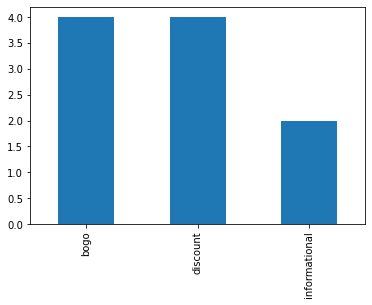

In [29]:
pd.value_counts(portfolio['offer_type']).plot.bar()

In [30]:
# one hot encode the channels column
portfolio = pd.concat([
        portfolio.drop("channels", 1),
        portfolio.channels.apply(lambda x: pd.Series(1, x)).fillna(0)
    ], axis=1)

portfolio.head(10)

C:\Users\laraibshahzil\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0


In [31]:
# one hot encode the offer type column
portfolio = pd.concat([
        portfolio.drop("offer_type", 1),
        pd.get_dummies(portfolio['offer_type'])
    ], axis=1)

portfolio.head(10)

C:\Users\laraibshahzil\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0,1,0


In [32]:
portfolio.rename(columns= { 'id':'offer_id' }, inplace=True)
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0,1,0


### 2. profile.json

In [33]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


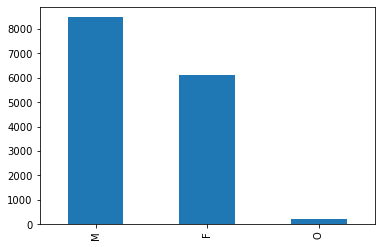

In [34]:
pd.value_counts(profile['gender']).plot.bar()

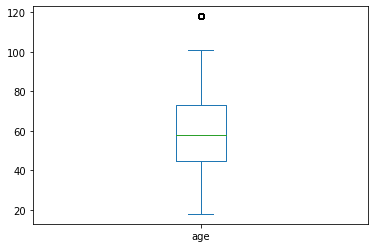

In [35]:
profile['age'].plot.box()

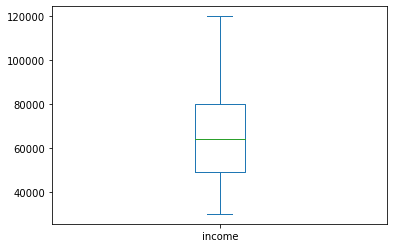

In [36]:
profile = profile[profile.income != 'O']
profile['income'].plot.box()

In [37]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [38]:
# replace NaN values with the mean value
profile.age.replace(118, np.nan, inplace=True)
profile.age.fillna(profile.age.mean(), inplace=True)

profile.income.fillna(profile.income.mean(), inplace=True)

profile.gender.fillna(profile.gender.mode()[0], inplace=True)

In [39]:
# one hot encode the gender column
profile = pd.concat([
        profile.drop("gender", 1),
        pd.get_dummies(profile['gender'])
    ], axis=1)

profile.head(10)

C:\Users\laraibshahzil\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,age,id,became_member_on,income,F,M,O
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0
1,55.000000,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,1,0,0
2,54.393524,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,0,1,0
3,75.000000,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,1,0,0
4,54.393524,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,0,1,0
5,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0
6,54.393524,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,65404.991568,0,1,0
7,54.393524,68617ca6246f4fbc85e91a2a49552598,20171002,65404.991568,0,1,0
8,65.000000,389bc3fa690240e798340f5a15918d5c,20180209,53000.000000,0,1,0
9,54.393524,8974fc5686fe429db53ddde067b88302,20161122,65404.991568,0,1,0


In [40]:
profile.rename(columns={'id':'customer_id'}, inplace=True)
profile.head()

,age,customer_id,became_member_on,income,F,M,O
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0
1,55.000000,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,1,0,0
2,54.393524,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,0,1,0
3,75.000000,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,1,0,0
4,54.393524,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,0,1,0


### 3. transcript.json

In [41]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


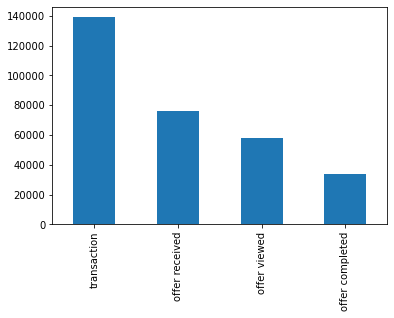

In [42]:
pd.value_counts(transcript['event']).plot.bar()

In [43]:
# value column consists of dictionaries whose value depends on 
# the event type.
transcript_events = set(transcript.event)

In [44]:
# unique values from value column
for event in transcript_events:
    temp = transcript[transcript['event'] == 'offer completed']

    values = set()
    for key, value in temp.value.items():
        for i in list(value.keys()):
            values.add(i)


In [45]:
# separate columns for offer_id, amount and reward
transcript['value_offer_id'] = transcript.value.tolist()
transcript['value_amount']   = transcript.value.tolist()
transcript['value_reward']   = transcript.value.tolist()

In [46]:
# functions to extract the amount, reward and offer_id from dict in value column 
def keep_amount_or_reward(x, pop):
    try:
        return x[pop]
    except KeyError:
        return 0
    
def keep_offer_id(x):
    try:
        return x['offer_id']
    except KeyError:
        try:
            return x['offer id']
        except KeyError:
            return 0

In [50]:
# Extracting value col to other cols
transcript.value_offer_id = transcript.value_offer_id.apply(keep_offer_id)
transcript.value_amount   = transcript.value_amount.apply(keep_amount_or_reward, pop='amount')
transcript.value_reward   = transcript.value_reward.apply(keep_amount_or_reward, pop='reward')

#Dropping value col
transcript.drop('value', axis=1, inplace=True)
transcript.head(10)

,person,event,time,value_offer_id,value_amount,value_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0.0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0


In [51]:
# convert time in hours to time in days
transcript['time'] = transcript['time']/24

In [52]:
transcript.rename(columns={'value_offer_id':'offer_id', 'person':'customer_id'}, inplace=True)

In [53]:
df = profile.merge(transcript, on='customer_id', how='left')

In [56]:
df.head(10)

,age,customer_id,became_member_on,income,F,M,O,event,time,offer_id,value_amount,value_reward
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,7.00,2906b810c7d4411798c6938adc9daaa5,0.00,0
1,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,9.00,2906b810c7d4411798c6938adc9daaa5,0.00,0
2,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,14.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0
3,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,14.50,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0
4,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,transaction,15.00,0,0.35,0
5,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,17.00,fafdcd668e3743c1bb461111dcafc2a4,0.00,0
6,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,17.00,fafdcd668e3743c1bb461111dcafc2a4,0.00,0
7,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,transaction,17.25,0,0.74,0
8,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,transaction,18.50,0,1.89,0
9,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,21.00,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0


In [57]:
#for viewed, received, transaction records, forward fill the offers
miss_offer = df[(df['event']=='transaction')|(df['event']=='offer viewed')|(df['event']=='offer received')][['time','offer_id','customer_id','event']]
miss_offer['offer_id'] = miss_offer['offer_id'].replace(0,np.nan)
miss_offer.ffill(axis=0,inplace=True)
miss_offer

,time,offer_id,customer_id,event
0,7.00,2906b810c7d4411798c6938adc9daaa5,68be06ca386d4c31939f3a4f0e3dd783,offer received
1,9.00,2906b810c7d4411798c6938adc9daaa5,68be06ca386d4c31939f3a4f0e3dd783,offer viewed
2,14.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,68be06ca386d4c31939f3a4f0e3dd783,offer received
3,14.50,0b1e1539f2cc45b7b9fa7c272da2e1d7,68be06ca386d4c31939f3a4f0e3dd783,offer viewed
4,15.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,68be06ca386d4c31939f3a4f0e3dd783,transaction
...,...,...,...,...
306528,20.00,f19421c1d4aa40978ebb69ca19b0e20d,e4052622e5ba45a8b96b59aba68cf068,transaction
306530,20.25,f19421c1d4aa40978ebb69ca19b0e20d,e4052622e5ba45a8b96b59aba68cf068,transaction
306531,22.75,f19421c1d4aa40978ebb69ca19b0e20d,e4052622e5ba45a8b96b59aba68cf068,offer viewed
306532,24.00,3f207df678b143eea3cee63160fa8bed,e4052622e5ba45a8b96b59aba68cf068,offer received


In [58]:
#merged with the main df and cleanup the offer id
df = df.merge(miss_offer, how = 'left', on=['customer_id','time','event'])
df['new_offer_id']=np.where(df['offer_id_x']==0,df['offer_id_y'],df['offer_id_x'])

#free up the memory
del miss_offer

#drop unnecessary columns and rename the offer id
df.drop(['offer_id_x','offer_id_y'], axis=1, inplace=True)
df = df.rename(columns={'new_offer_id':'offer_id'})

# merging dataset with the offer portfolio
df = df.merge(portfolio, on='offer_id')

In [59]:
df

,age,customer_id,became_member_on,income,F,M,O,event,time,value_amount,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,7.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
1,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,9.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
2,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer received,0.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
3,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer viewed,0.75,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
4,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,transaction,12.00,17.88,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer viewed,14.25,0.00,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306530,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,14.50,9.49,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306531,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,15.00,10.75,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306532,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer completed,15.00,0.00,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0


In [349]:
# save the merged dataset
df.to_csv('data/merged_data.csv', index=False)

In [350]:
df = pd.read_csv('data/merged_data.csv')
df

,age,customer_id,became_member_on,income,F,M,O,event,time,value_amount,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,7.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
1,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,9.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
2,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer received,0.00,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
3,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer viewed,0.75,0.00,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
4,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,transaction,12.00,17.88,...,2,10,7,1.0,1.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer viewed,14.25,0.00,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306530,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,14.50,9.49,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306531,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,15.00,10.75,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0
306532,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer completed,15.00,0.00,...,10,10,5,1.0,1.0,1.0,1.0,1,0,0


#### Now our goal is to determine the offer success, for that we know that the offer is considered successful when a customer views and avails the offer within the validity period

In [351]:
# first determine the correct flow of offer transaction, 
# find the previous event of each offer for customer
df['previous_offer_id'] = df.groupby(['customer_id'])['offer_id'].shift()
df['previous_event']    = df.groupby(['customer_id'])['event'].shift()


# for every transaction determine the previous event, if the previous event is
# offer viewed for the same offer_id, then customer availed the offer
df['avail_offer'] = 0
df.loc[((df['previous_offer_id']==df['offer_id'])\
                          &(df['event']=='transaction')\
                          &(df['previous_event']=='offer viewed')),'avail_offer']=1

In [352]:
# second determine if the offer was availed within the validity period
df['time_diff'] = df.groupby(['customer_id','offer_id'])['time'].diff()
df['offer_validity'] = 0
df.loc[df['time_diff']<=df['duration'],'offer_validity']=1


In [353]:
# determine offer success based on the above two conditions
df['offer_success']=np.where((df['avail_offer']==1)\
                                               &(df['offer_validity']==1),1,0)

# drop extra columns
df.drop(['previous_event','previous_offer_id','avail_offer','offer_validity', 'time_diff'], axis=1, inplace=True)
df

,age,customer_id,became_member_on,income,F,M,O,event,time,value_amount,...,difficulty,duration,email,mobile,social,web,bogo,discount,informational,offer_success
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer received,7.00,0.00,...,10,7,1.0,1.0,0.0,1.0,0,1,0,0
1,54.393524,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,0,1,0,offer viewed,9.00,0.00,...,10,7,1.0,1.0,0.0,1.0,0,1,0,0
2,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer received,0.00,0.00,...,10,7,1.0,1.0,0.0,1.0,0,1,0,0
3,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,offer viewed,0.75,0.00,...,10,7,1.0,1.0,0.0,1.0,0,1,0,0
4,68.000000,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,0,1,0,transaction,12.00,17.88,...,10,7,1.0,1.0,0.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer viewed,14.25,0.00,...,10,5,1.0,1.0,1.0,1.0,1,0,0,0
306530,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,14.50,9.49,...,10,5,1.0,1.0,1.0,1.0,1,0,0,1
306531,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,transaction,15.00,10.75,...,10,5,1.0,1.0,1.0,1.0,1,0,0,0
306532,83.000000,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000,1,0,0,offer completed,15.00,0.00,...,10,5,1.0,1.0,1.0,1.0,1,0,0,0


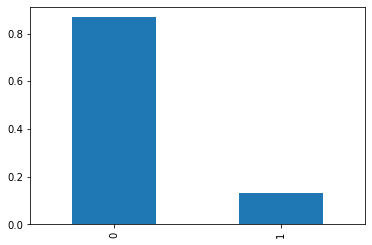

In [354]:
pd.value_counts(df['offer_success'], normalize=True).plot.bar()

In [355]:
df.isnull().sum()

age                 0
customer_id         0
became_member_on    0
income              0
F                   0
M                   0
O                   0
event               0
time                0
value_amount        0
value_reward        0
offer_id            0
reward              0
difficulty          0
duration            0
email               0
mobile              0
social              0
web                 0
bogo                0
discount            0
informational       0
offer_success       0
dtype: int64

###### As we can see that the data is quite unbalance and that can be due to duplicate and redundant data. So we will have to get rid of repetitive information and extract only necessary info

In [356]:
#number of events for each offer id for every customer
event_count = df.groupby(['customer_id','offer_id','event'])['event'].count().unstack('event').reset_index()
event_count

event,customer_id,offer_id,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,NaN,4.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,1.0,1.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,1.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...
65039,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.0,2.0,2.0,6.0
65040,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0,5.0
65041,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3.0,3.0,3.0,6.0
65042,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,1.0


In [357]:
# determine the offers availed by each customer 
df_offer_success = df.groupby(['customer_id','offer_id']).agg({'offer_success':'max','value_amount':'sum'}).reset_index()
df_offer_success

,customer_id,offer_id,offer_success,value_amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,69.20
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,0.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,22.16
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,8.57
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,27.67
...,...,...,...,...
65039,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1,46.77
65040,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,96.37
65041,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,89.55
65042,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.79


In [359]:
# get rid of redundant data
df_columns = df[['customer_id','offer_id','age','income','became_member_on',
             'reward','difficulty','duration', 'web','email','mobile','social'
            ]].drop_duplicates()
df_columns

,customer_id,offer_id,age,income,became_member_on,reward,difficulty,duration,web,email,mobile,social
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,54.393524,65404.991568,20170212,2,10,7,1.0,1.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,68.000000,70000.000000,20180426,2,10,7,1.0,1.0,1.0,0.0
6,8ec6ce2a7e7949b1bf142def7d0e0586,2906b810c7d4411798c6938adc9daaa5,54.393524,65404.991568,20170925,2,10,7,1.0,1.0,1.0,0.0
8,68617ca6246f4fbc85e91a2a49552598,2906b810c7d4411798c6938adc9daaa5,54.393524,65404.991568,20171002,2,10,7,1.0,1.0,1.0,0.0
10,389bc3fa690240e798340f5a15918d5c,2906b810c7d4411798c6938adc9daaa5,65.000000,53000.000000,20180209,2,10,7,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
306516,54bead4179c44b71acc4e8398181d183,4d5c57ea9a6940dd891ad53e9dbe8da0,29.000000,58000.000000,20170220,10,10,5,1.0,1.0,1.0,1.0
306520,ff737c250d2343729ade04c4f6eb1001,4d5c57ea9a6940dd891ad53e9dbe8da0,72.000000,65000.000000,20150404,10,10,5,1.0,1.0,1.0,1.0
306524,c02b10e8752c4d8e9b73f918558531f7,4d5c57ea9a6940dd891ad53e9dbe8da0,54.393524,65404.991568,20151211,10,10,5,1.0,1.0,1.0,1.0
306526,6d5f3a774f3d4714ab0c092238f3a1d7,4d5c57ea9a6940dd891ad53e9dbe8da0,45.000000,54000.000000,20180604,10,10,5,1.0,1.0,1.0,1.0


In [360]:
df_offer_rcvd = df[df['event']=='offer received'][['customer_id','offer_id','time']]
df_offer_rcvd

,customer_id,offer_id,time
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,7.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0
6,8ec6ce2a7e7949b1bf142def7d0e0586,2906b810c7d4411798c6938adc9daaa5,17.0
8,68617ca6246f4fbc85e91a2a49552598,2906b810c7d4411798c6938adc9daaa5,17.0
10,389bc3fa690240e798340f5a15918d5c,2906b810c7d4411798c6938adc9daaa5,14.0
...,...,...,...
306516,54bead4179c44b71acc4e8398181d183,4d5c57ea9a6940dd891ad53e9dbe8da0,14.0
306520,ff737c250d2343729ade04c4f6eb1001,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
306524,c02b10e8752c4d8e9b73f918558531f7,4d5c57ea9a6940dd891ad53e9dbe8da0,14.0
306526,6d5f3a774f3d4714ab0c092238f3a1d7,4d5c57ea9a6940dd891ad53e9dbe8da0,14.0


In [361]:
balanced_df = event_count[['customer_id','offer_id','offer received','offer viewed','transaction','offer completed']]\
             .merge(df_offer_success, on = ['customer_id','offer_id'], how='left' )
balanced_df = balanced_df.merge(df_columns, on = ['customer_id','offer_id'], how='left' )
balanced_df = balanced_df.merge(df_offer_rcvd, on = ['customer_id','offer_id'], how='left' )

balanced_df.shape

(78033, 19)

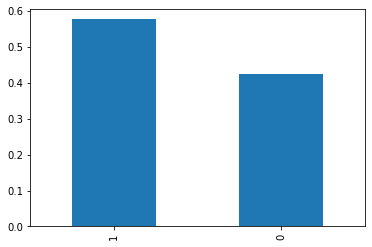

In [362]:
pd.value_counts(balanced_df['offer_success'], normalize=True).plot.bar()

In [363]:
# removing unncessary columns
balanced_df.drop(['customer_id', 'offer_id', 'became_member_on', 'time'], inplace=True, axis=1)

In [364]:
balanced_df = balanced_df[ [ col for col in balanced_df.columns if col != 'offer_success' ] + ['offer_success'] ]


In [366]:
balanced_df.fillna(0, inplace=True)
balanced_df.to_csv('data/balanced_df.csv', index=False)